In [62]:
import requests
from bs4 import BeautifulSoup
from io import StringIO

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [63]:
df_circuits = pd.read_csv("data/circuits.csv")
df_constructors = pd.read_csv("data/constructors.csv")
df_constructor_results = pd.read_csv("data/constructor_results.csv")
df_constructor_standings = pd.read_csv("data/constructor_standings.csv")
df_driver_standings = pd.read_csv("data/driver_standings.csv")
df_drivers = pd.read_csv("data/drivers.csv")
df_lap_times = pd.read_csv("data/lap_times.csv")
df_pit_stops = pd.read_csv("data/pit_stops.csv")
df_qualifying = pd.read_csv("data/qualifying.csv")
df_results = pd.read_csv("data/results.csv")
df_seasons = pd.read_csv("data/seasons.csv")
df_sprint_results = pd.read_csv("data/sprint_results.csv")
df_status = pd.read_csv("data/status.csv")
df_races = pd.read_csv("data/races.csv")
df_weather = pd.read_csv("data/weather.csv")
df_status = pd.read_csv("data/status.csv")



In [64]:
len_turn_data = []

def length_turn(url, cId):
    response = requests.get(url)

    # Parse the HTML content
    soup = BeautifulSoup(response.content, "html.parser")

    # Find the table element
    table = soup.find("table", class_="infobox")
    df = pd.read_html(StringIO(str(table)))[0]
    
    # If Length/Turns is not available set them to 0.
    try:
        length = df.loc[np.where(df == 'Length')[0][0]].iloc[1]
        turns = df.loc[np.where(df == 'Turns')[0][0]].iloc[1]
    except IndexError:
        length = '0.0000'
        turns = '0'

    # Append the List: [circuitId, Length, Turns]
    len_turn_data.append([cId, length, turns])

# Function to extract Length and Turns for each circuit according to circuitId
for cId, url in zip(df_circuits.circuitId, df_circuits.url):
    length_turn(url, cId)

# Convert the Length and Turns column in float and int types
df_len_turn = pd.DataFrame(data=len_turn_data, columns=["circuitId", "Length", "Turns"])

df_len_turn['Length'] = df_len_turn['Length'].str[:5].astype(float)
df_len_turn['Turns'] = df_len_turn['Turns'].str[:2].astype(int)

# Merge the Length & Turns dataframe to df_circuits according to circuitId
df_circuits = df_circuits.merge(df_len_turn, on='circuitId', how='left')

In [65]:
# Circuits
df_circuits

# Replaces '\N' values with NaN
df_circuits['alt'] = df_circuits['alt'].replace('\\N', np.nan)
df_circuits['alt'] = df_circuits['alt'].astype(float)

df_circuits[df_circuits['alt'].isna()] # 3 rows
df_circuits[df_circuits['Length']==0.000] # 7 rows

# Replacing missing values with mean of data
df_circuits['Length'] = df_circuits['Length'].replace(0, df_circuits[df_circuits['Length'] != 0]['Length'].mean()).astype(float)
df_circuits['Turns'] = df_circuits['Turns'].replace(0, df_circuits[df_circuits['Turns'] != 0]['Turns'].mean()).astype(int)
df_circuits.loc[:, 'alt'] = df_circuits['alt'].fillna(df_circuits['alt'].mean()).astype(int)

df_circuits['laps'] = (305/df_circuits['Length']).astype(int)

df_circuits.to_csv('circuits.csv', index=False)



In [66]:
df_constructor_results

,constructorResultsId,raceId,constructorId,points,status
0,1,18,1,14.0,\N
1,2,18,2,8.0,\N
2,3,18,3,9.0,\N
3,4,18,4,5.0,\N
4,5,18,5,2.0,\N
...,...,...,...,...,...
12500,17005,1132,117,10.0,\N
12501,17006,1132,3,2.0,\N
12502,17007,1132,215,1.0,\N
12503,17008,1132,15,0.0,\N


In [67]:
# Constructor Standings
df_constructor_standings

df_constructor_standings = df_constructor_standings.merge(df_constructors[['constructorId', 'name']], on='constructorId', how='left')

df_constructor_standings = df_constructor_standings.merge(df_races[['raceId', 'date']], on='raceId')

In [68]:
# Drivers
df_drivers

# No need for driver number
df_drivers.drop('number', axis=1, inplace=True)

# Adding driver 'Name' column instead of forename and surname
df_drivers['Name'] = df_drivers['forename'] + ' ' + df_drivers['surname']

# Adding code for each driver i.e, the first 3 letter of the surname
df_drivers['surname'] = df_drivers['surname'].str.replace(' ', '')

def replace_code(row):
    if row['code'] == '\\N':
        return row['surname'][:3].upper()
    else:
        return row['code']

df_drivers['code'] = df_drivers.apply(replace_code, axis=1)

# Dropping columns
df_drivers.drop(columns=['driverRef', 'forename', 'surname', 'url'], axis=1, inplace=True)

df_drivers.to_csv('drivers.csv', index=False)

In [69]:
df_driver_standings

df_driver_standings = df_driver_standings.merge(df_drivers[['driverId', 'Name']], on='driverId', how='left')

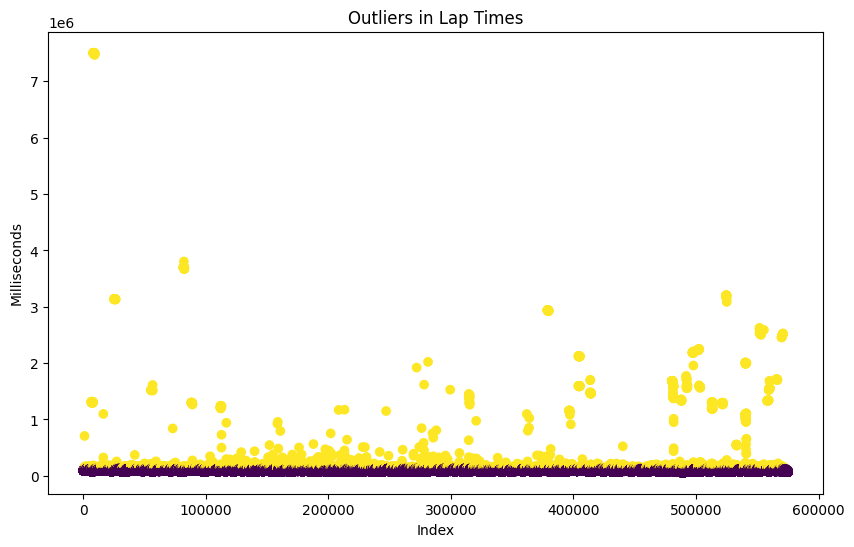

In [70]:
# Lap Times
df_lap_times

df_lap_times = df_lap_times[df_lap_times['raceId'].isin(df_races['raceId'])]

# Assuming df_lap_times is your DataFrame and 'milliseconds' is the column with lap times
Q1 = df_lap_times['milliseconds'].quantile(0.25)
Q3 = df_lap_times['milliseconds'].quantile(0.75)
IQR = Q3 - Q1

# Define a filter for outliers
filter = (df_lap_times['milliseconds'] >= Q1 - 1.5 * IQR) & (df_lap_times['milliseconds'] <= Q3 + 1.5 *IQR)

# Create a new column 'outlier' that is True where the row is an outlier and False otherwise
df_lap_times['outlier'] = ~filter

# Plot the 'milliseconds' column, coloring by the 'outlier' column
plt.figure(figsize=(10, 6))
plt.scatter(df_lap_times.index, df_lap_times['milliseconds'], c=df_lap_times['outlier'])
plt.title('Outliers in Lap Times')
plt.xlabel('Index')
plt.ylabel('Milliseconds')
plt.show()


In [71]:
# Removing lap times above 10 minutes

df_lap_times = df_lap_times[df_lap_times['milliseconds'] < 600000]

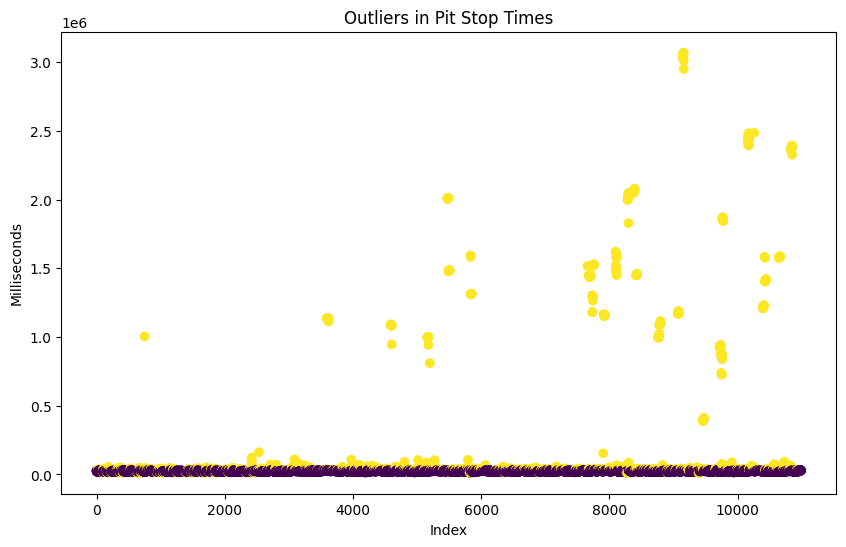

In [72]:
# Pit Stops
df_pit_stops

df_pit_stops = df_pit_stops[df_pit_stops['raceId'].isin(df_races['raceId'])]

import matplotlib.pyplot as plt

# Assuming df_pit_stops is your DataFrame and 'milliseconds' is the column with lap times
Q1 = df_pit_stops['milliseconds'].quantile(0.25)
Q3 = df_pit_stops['milliseconds'].quantile(0.75)
IQR = Q3 - Q1

# Define a filter for outliers
filter = (df_pit_stops['milliseconds'] >= Q1 - 1.5 * IQR) & (df_pit_stops['milliseconds'] <= Q3 + 1.5 *IQR)

# Create a new column 'outlier' that is True where the row is an outlier and False otherwise
df_pit_stops['outlier'] = ~filter

# Plot the 'milliseconds' column, coloring by the 'outlier' column
plt.figure(figsize=(10, 6))
plt.scatter(df_pit_stops.index, df_pit_stops['milliseconds'], c=df_pit_stops['outlier'])
plt.title('Outliers in Pit Stop Times')
plt.xlabel('Index')
plt.ylabel('Milliseconds')
plt.show()

# Todo: Lap times acc to drivers



In [73]:
# Removing pit stop times above 10 minutes

df_pit_stops = df_pit_stops[df_pit_stops['milliseconds'] < 500000]

In [74]:
# Qualifying
df_qualifying

# Converting q1, q2, q3 into milliseconds
def convert_to_seconds(time_str):
    if pd.isnull(time_str):
        return np.nan
    minutes, seconds = time_str.split(':')
    total_seconds = int(minutes) * 60 + float(seconds)
    return total_seconds

columns = ['q1', 'q2', 'q3']

for column in columns:
    df_qualifying[column] = df_qualifying[column].replace('\\N', np.nan)
    df_qualifying[column] = df_qualifying[column].apply(convert_to_seconds)

# Storing the average of q1, q2, q3 in time column
df_qualifying['Qualifying Time'] = df_qualifying[['q1', 'q2', 'q3']].mean(axis=1).round(3)

# Time converted from M:S.ms to ms
# Averaged the 3 columns q1, q2, q3 to get qualifying time


In [75]:
# Results
df_results

df_results['position'] = df_results['position'].replace('\\N', 0)
df_results['milliseconds'] = df_results['milliseconds'].replace('\\N', 0)
df_results['fastestLapTime'] = df_results['fastestLapTime'].replace('\\N', 0)
df_results['fastestLapSpeed'] = df_results['fastestLapSpeed'].replace('\\N', 0)


df_results['position'] = df_results['position'].astype(int)
df_results['milliseconds'] = df_results['milliseconds'].astype(float)
df_results['fastestLapSpeed'] = df_results['fastestLapSpeed'].astype(float)


df_results['milliseconds'] = df_results['milliseconds'] / 1000
df_results = df_results.rename(columns={'milliseconds': 'seconds'})

df_results = df_results.merge(df_races[['raceId', 'date', 'circuitId']], on='raceId')
# Time converted from M:S.ms to ms
# Dates added

In [76]:
# Sprint Results
df_sprint_results

df_sprint_results['fastestLapTime'] = df_sprint_results['fastestLapTime'].replace('\\N', np.nan)

df_sprint_results = df_sprint_results.merge(df_races[['raceId', 'date']], on='raceId')

# Time converted from M:S.ms to ms
# Dates added

In [77]:
# Weather
df_weather

df_weather.drop(columns='Time', inplace=True)

# Function to get store Round Year-wise and calculate average
def weatherAverage(df_weather, year):
    df_year = df_weather[df_weather['Year'] == year]
    df_weather = df_weather[df_weather['Year'] != year]
    rainfall = df_weather['Rainfall']
    df_year = df_year.groupby('Round Number').mean().round(1).reset_index()
    
    df_weather = pd.concat([df_weather, df_year])
    return df_weather

years = [x for x in range(2018, 2024)]

for year in years:
    df_weather = weatherAverage(df_weather, year)

# Now I'll add the circuitId and RaceId for to the weather dataset
df_weather = df_weather.rename(columns={"Year": "year", "Round Number": "round"})
df_weather = pd.merge(df_weather, df_races[['raceId', 'circuitId', 'year', 'round']], on=['year', 'round'], how='left')

TypeError: agg function failed [how->mean,dtype->object]